## Example Notebook for Running the Simulator and Plotting Results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.analysis import pairplot
from simulator import modified_TM, mean_function,from_means

### Modified Two Moons Simulator

The two moons simulator is a common example of a low-dimensional simulator where the posterior is complicated. 
Here, $\theta$ is a two-dimensional vector sampled from a uniform prior $\mathcal{U}(-1,1)$, and is mapped into two-dimensional outputs $x$ as follows:

\begin{equation*}
x|\theta = \begin{bmatrix} r\cos\alpha + 0.25 \\ r\sin\alpha \end{bmatrix} + \begin{bmatrix} |-\theta_1 + \theta_2|/\sqrt{2} + \epsilon \\ (-\theta_1 + \theta_2)/\sqrt{2} +\epsilon \end{bmatrix}
\end{equation*}

Where $r\sim \mathcal{N}(0.1,0.01^{2})$, $\alpha\sim \mathcal{U}(-\pi/2,\pi/2)$ and $\epsilon\sim\mathcal{N}(0,0.1^{2})$. The addition of $\epsilon$ is new here, and is not normally part of the two moons simulator.
Here, we will treat the means $\begin{bmatrix} |-\theta_1 + \theta_2|/\sqrt{2} + \epsilon \\ (-\theta_1 + \theta_2)/\sqrt{2} +\epsilon \end{bmatrix}$ as an intermediate, latent variable.

In [3]:
prior = BoxUniform(low=torch.tensor([-1.0,-1.0]), high=torch.tensor([1.0,1.0]))
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(modified_TM, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

In [4]:
theta = prior.sample((1000,))
x = simulator(theta)
print(theta.shape)
print(x.shape)

torch.Size([1000, 2])
torch.Size([1000, 2])


In [5]:

means = mean_function(theta)
x_from_means = from_means(means)

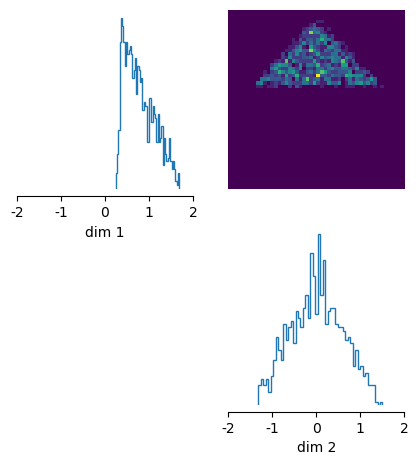

In [6]:
_ = pairplot(x, limits=[[-2, 2], [-2, 2]], figsize=(5, 5))

In [7]:
inference = SNPE()
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Neural network successfully converged after 162 epochs.

In [8]:
theta_o = prior.sample((1,))
x_o = simulator(theta_o)

In [9]:
posterior = inference.build_posterior(density_estimator)

In [10]:
posterior.set_default_x(x_o)
post_samples = posterior.sample((1000,))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

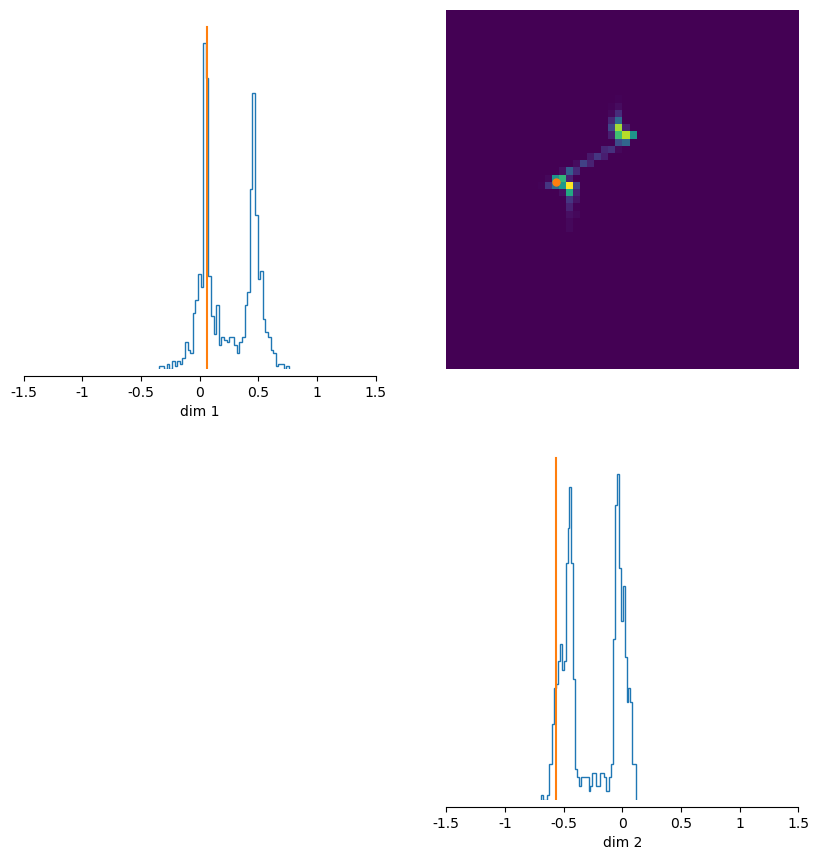

In [11]:
_ = pairplot(post_samples,limits =[[-1.5,1.5],[-1.5,1.5]], points = theta_o)